#  Importing Library

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 
import yfinance as yf 
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

# Importing the Data using the yfinance

In [2]:
def get_historical_data(symbol, start_date = None):
    df=yf.download(symbol, start=start_date)
    return (df)
ibm = get_historical_data('IBM', '2010-01-01')
print(ibm)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-12-31  126.586998  127.007645  125.000000  125.143402   82.345901   
2010-01-04  125.411087  127.122368  125.095604  126.625237   83.320969   
2010-01-05  125.889099  126.051628  124.378586  125.095604   82.314438   
2010-01-06  124.933075  125.707458  124.101341  124.282982   81.779732   
2010-01-07  124.158699  124.521988  123.240921  123.852776   81.496666   
...                ...         ...         ...         ...         ...   
2022-05-09  134.410004  136.350006  133.320007  134.440002  134.440002   
2022-05-10  135.000000  135.410004  128.429993  129.130005  129.130005   
2022-05-11  129.860001  132.960007  129.860001  130.750000  130.750000   
2022-05-12  131.270004  133.619995  130.410004  132.899994  132.899994   
2022-05-13  133.000000  133.800003  131.050

# ADX Calculation

In [3]:
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

ibm['plus_di'] = pd.DataFrame(get_adx(ibm['High'], ibm['Low'], ibm['Close'], 14)[0]).rename(columns = {0:'plus_di'})
ibm['minus_di'] = pd.DataFrame(get_adx(ibm['High'], ibm['Low'], ibm['Close'], 14)[1]).rename(columns = {0:'minus_di'})
ibm['adx'] = pd.DataFrame(get_adx(ibm['High'], ibm['Low'], ibm['Close'], 14)[2]).rename(columns = {0:'adx'})
ibm = ibm.dropna()


# RSI Calculation

In [5]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    
    return rsi_df[3:]

ibm['rsi_14'] =get_rsi(ibm['Close'], 14)
ibm = ibm.dropna()
ibm.tail()

C:\Users\asus\AppData\Local\Temp/ipykernel_16440/297694007.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibm['rsi_14'] =get_rsi(ibm['Close'], 14)


,Open,High,Low,Close,Adj Close,Volume,plus_di,minus_di,adx,rsi_14
Date,,,,,,,,,,
2022-05-09,134.410004,136.350006,133.320007,134.440002,134.440002,7647900,22.560069,16.809417,21.933778,52.846098
2022-05-10,135.000000,135.410004,128.429993,129.130005,129.130005,8642400,22.360299,26.267672,21.376899,43.236101
2022-05-11,129.860001,132.960007,129.860001,130.750000,130.750000,5301100,21.052659,24.731527,20.423923,46.436355
2022-05-12,131.270004,133.619995,130.410004,132.899994,132.899994,5384800,20.813864,22.910226,19.522483,50.430596
2022-05-13,133.000000,133.800003,131.050003,133.600006,133.600006,4195100,20.377356,22.022146,18.465816,51.693649


# RSI Plotting using MatplotLib

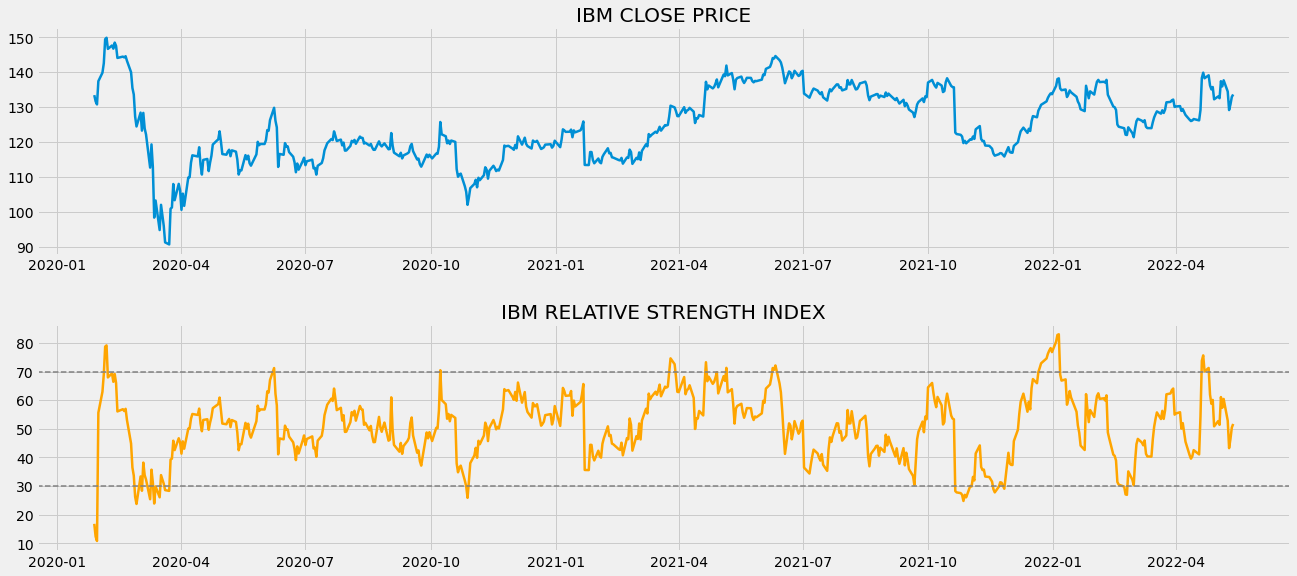

In [6]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['Close'], linewidth = 2.5)
ax1.set_title('IBM CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('IBM RELATIVE STRENGTH INDEX')
a=plt.show()

# ADX Plotting using MatplotLib

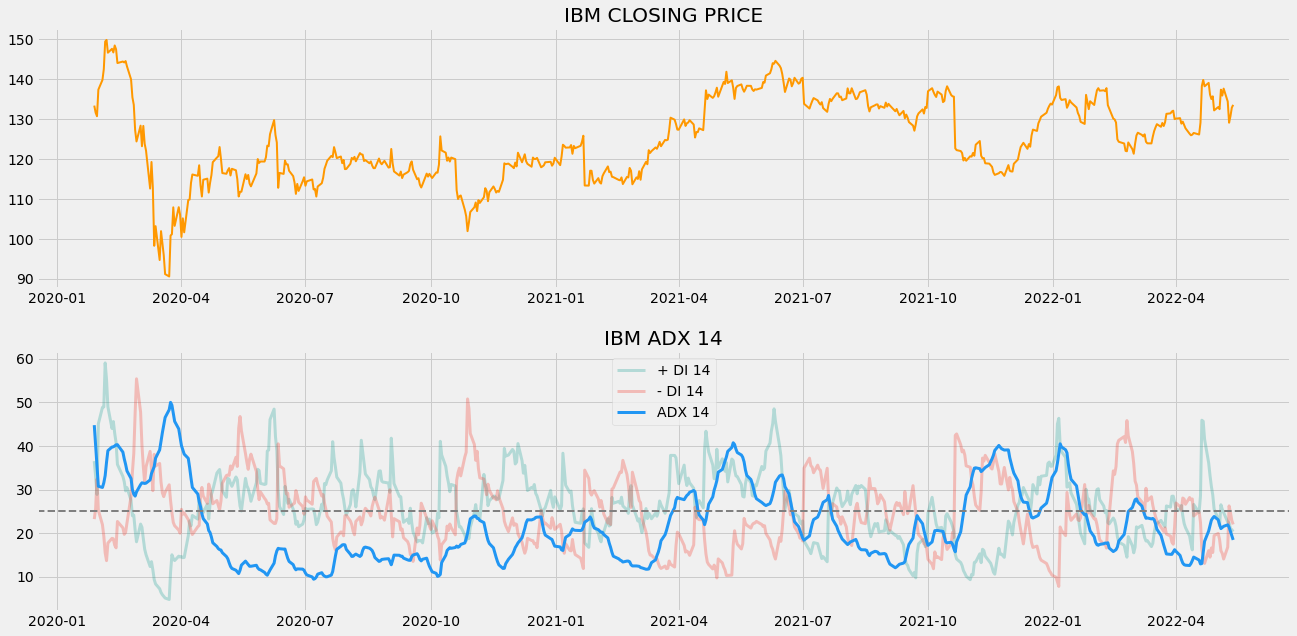

In [7]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(ibm['Close'], linewidth = 2, color = '#ff9800')
ax1.set_title('IBM CLOSING PRICE')
ax2.plot(ibm['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(ibm['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(ibm['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('IBM ADX 14')
plt.show()

# Bollinger Bands calculation

In [8]:
def sma(data, lookback):
    sma = data.rolling(lookback).mean()
    return sma

def get_bb(data, lookback):
    std = data.rolling(lookback).std()
    upper_bb = sma(data, lookback) + std * 2
    lower_bb = sma(data, lookback) - std * 2
    middle_bb = sma(data, lookback)
    return upper_bb, middle_bb, lower_bb

ibm['upper_bb'], ibm['middle_bb'], ibm['lower_bb'] = get_bb(ibm['Close'], 20)
ibm.tail()

,Open,High,Low,Close,Adj Close,Volume,plus_di,minus_di,adx,rsi_14,upper_bb,middle_bb,lower_bb
Date,,,,,,,,,,,,,
2022-05-09,134.410004,136.350006,133.320007,134.440002,134.440002,7647900,22.560069,16.809417,21.933778,52.846098,143.101353,133.304001,123.506649
2022-05-10,135.000000,135.410004,128.429993,129.130005,129.130005,8642400,22.360299,26.267672,21.376899,43.236101,142.899991,133.442001,123.984011
2022-05-11,129.860001,132.960007,129.860001,130.750000,130.750000,5301100,21.052659,24.731527,20.423923,46.436355,142.569670,133.680501,124.791331
2022-05-12,131.270004,133.619995,130.410004,132.899994,132.899994,5384800,20.813864,22.910226,19.522483,50.430596,142.185153,134.018501,125.851848
2022-05-13,133.000000,133.800003,131.050003,133.600006,133.600006,4195100,20.377356,22.022146,18.465816,51.693649,141.752774,134.370501,126.988228


#  Keltner Channel Calculation

In [9]:
def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower
    
ibm['kc_middle'], ibm['kc_upper'], ibm['kc_lower'] = get_kc(ibm['High'], ibm['Low'], ibm['Close'], 20, 2, 10)
ibm.tail()

,Open,High,Low,Close,Adj Close,Volume,plus_di,minus_di,adx,rsi_14,upper_bb,middle_bb,lower_bb,kc_middle,kc_upper,kc_lower
Date,,,,,,,,,,,,,,,,
2022-05-09,134.410004,136.350006,133.320007,134.440002,134.440002,7647900,22.560069,16.809417,21.933778,52.846098,143.101353,133.304001,123.506649,132.044401,138.667260,125.421541
2022-05-10,135.000000,135.410004,128.429993,129.130005,129.130005,8642400,22.360299,26.267672,21.376899,43.236101,142.899991,133.442001,123.984011,131.905620,139.262196,124.549044
2022-05-11,129.860001,132.960007,129.860001,130.750000,130.750000,5301100,21.052659,24.731527,20.423923,46.436355,142.569670,133.680501,124.791331,131.850590,139.237509,124.463672
2022-05-12,131.270004,133.619995,130.410004,132.899994,132.899994,5384800,20.813864,22.910226,19.522483,50.430596,142.185153,134.018501,125.851848,131.900562,139.190787,124.610337
2022-05-13,133.000000,133.800003,131.050003,133.600006,133.600006,4195100,20.377356,22.022146,18.465816,51.693649,141.752774,134.370501,126.988228,131.981488,139.092690,124.870285


# Plotting Bollinger Bands values

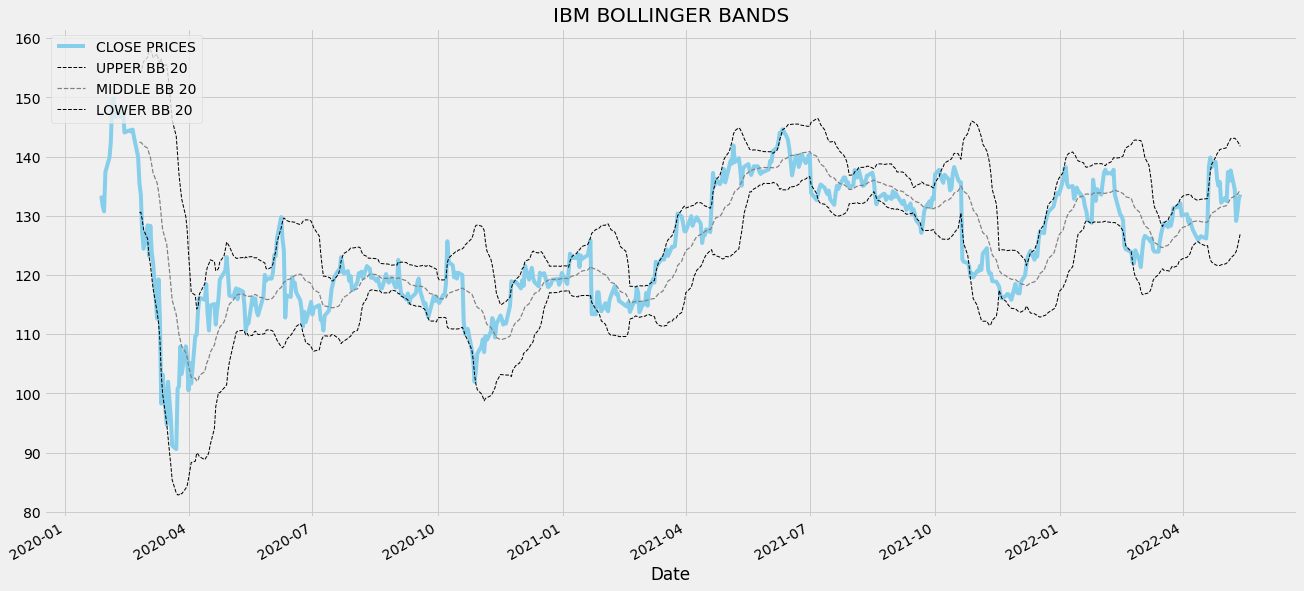

In [10]:
ibm['Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
ibm['upper_bb'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
ibm['middle_bb'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
ibm['lower_bb'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc = 'upper left')
plt.title('IBM BOLLINGER BANDS')
plt.show()

# Plotting the Keltner Channel values

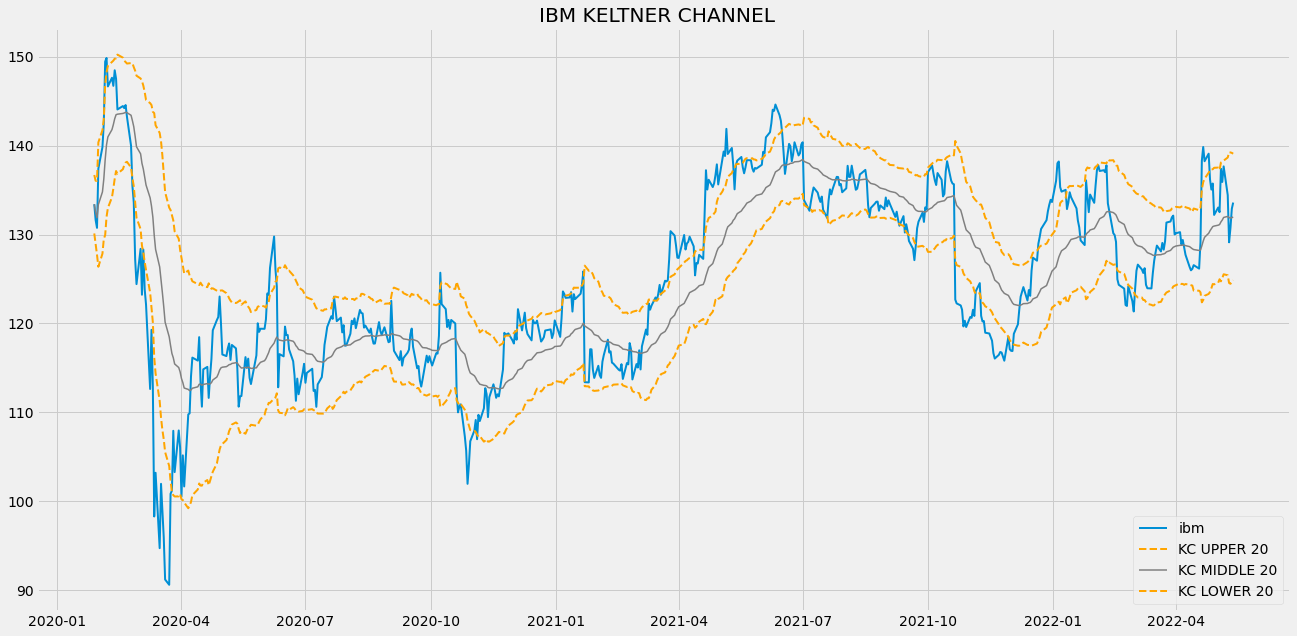

In [11]:
plt.plot(ibm['Close'], linewidth = 2, label = 'ibm')
plt.plot(ibm['kc_upper'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(ibm['kc_middle'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(ibm['kc_lower'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.legend(loc = 'lower right')
plt.title('IBM KELTNER CHANNEL  ')
plt.show()

# Creating the Trading Strategy using BB,KC and RSI

In [12]:
def bb_kc_rsi_strategy(prices, upper_bb, lower_bb, kc_upper, kc_lower, rsi):
    buy_price = []
    sell_price = []
    bb_kc_rsi_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if lower_bb[i] < kc_lower[i] and upper_bb[i] > kc_upper[i] and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                bb_kc_rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_kc_rsi_signal.append(0)
                
        elif lower_bb[i] < kc_lower[i] and upper_bb[i] > kc_upper[i] and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                bb_kc_rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_kc_rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_kc_rsi_signal.append(0)
                        
    return buy_price, sell_price, bb_kc_rsi_signal

buy_price, sell_price, bb_kc_rsi_signal = bb_kc_rsi_strategy(ibm['Close'], ibm['upper_bb'], ibm['lower_bb'], ibm['kc_upper'], ibm['kc_lower'], ibm['rsi_14'])

# Creating our Position of BB KC RSI

In [13]:
position = []
for i in range(len(bb_kc_rsi_signal)):
    if bb_kc_rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['Close'])):
    if bb_kc_rsi_signal[i] == 1:
        position[i] = 1
    elif bb_kc_rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
kc_upper = ibm['kc_upper']
kc_lower = ibm['kc_lower']
upper_bb = ibm['upper_bb'] 
lower_bb = ibm['lower_bb']
rsi = ibm['rsi_14']
close_price = ibm['Close']
bb_kc_rsi_signal = pd.DataFrame(bb_kc_rsi_signal).rename(columns = {0:'bb_kc_rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'bb_kc_rsi_position'}).set_index(ibm.index)

frames = [close_price, kc_upper, kc_lower, upper_bb, lower_bb, rsi, bb_kc_rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.tail()

,Close,kc_upper,kc_lower,upper_bb,lower_bb,rsi_14,bb_kc_rsi_signal,bb_kc_rsi_position
Date,,,,,,,,
2022-05-09,134.440002,138.667260,125.421541,143.101353,123.506649,52.846098,0,0
2022-05-10,129.130005,139.262196,124.549044,142.899991,123.984011,43.236101,0,0
2022-05-11,130.750000,139.237509,124.463672,142.569670,124.791331,46.436355,0,0
2022-05-12,132.899994,139.190787,124.610337,142.185153,125.851848,50.430596,0,0
2022-05-13,133.600006,139.092690,124.870285,141.752774,126.988228,51.693649,0,0


# Backtesting of BB KC RSI

In [14]:
ibm_ret = pd.DataFrame(np.diff(ibm['Close'])).rename(columns = {0:'returns'})
bb_kc_rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['bb_kc_rsi_position'][i]
    bb_kc_rsi_strategy_ret.append(returns)
    
bb_kc_rsi_strategy_ret_df = pd.DataFrame(bb_kc_rsi_strategy_ret).rename(columns = {0:'bb_kc_rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['Close'][0])
bb_kc_rsi_investment_ret = []

for i in range(len(bb_kc_rsi_strategy_ret_df['bb_kc_rsi_returns'])):
    returns = number_of_stocks*bb_kc_rsi_strategy_ret_df['bb_kc_rsi_returns'][i]
    bb_kc_rsi_investment_ret.append(returns)

bb_kc_rsi_investment_ret_df = pd.DataFrame(bb_kc_rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(bb_kc_rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = ((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the BB KC RSI strategy by investing 100k in ibm : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the BB KC RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the BB KC RSI strategy by investing 100k in ibm : 33312.11
Profit percentage of the BB KC RSI strategy : 33.31211%


# Creating the Trading Strategy using ADX and RSI

In [15]:
def adx_rsi_strategy(prices, adx, pdi, ndi, rsi):
    buy_price1 = []
    sell_price1 = []
    adx_rsi_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if adx[i] > 35 and pdi[i] < ndi[i] and rsi[i] < 50:
            if signal != 1:
                buy_price1.append(prices[i])
                sell_price1.append(np.nan)
                signal = 1
                adx_rsi_signal.append(signal)
            else:
                buy_price1.append(np.nan)
                sell_price1.append(np.nan)
                adx_rsi_signal.append(0)
                
        elif adx[i] > 35 and pdi[i] > ndi[i] and rsi[i] > 50:
            if signal != -1:
                buy_price1.append(np.nan)
                sell_price1.append(prices[i])
                signal = -1
                adx_rsi_signal.append(signal)
            else:
                buy_price1.append(np.nan)
                sell_price1.append(np.nan)
                adx_rsi_signal.append(0)
        else:
            buy_price1.append(np.nan)
            sell_price1.append(np.nan)
            adx_rsi_signal.append(0)
                        
    return buy_price1, sell_price1, adx_rsi_signal

buy_price1, sell_price1, adx_rsi_signal = adx_rsi_strategy(ibm['Close'], ibm['adx'], ibm['plus_di'], ibm['minus_di'], ibm['rsi_14'])

# Creating our Position using ADX and RSI

In [16]:
position1 = []
for i in range(len(adx_rsi_signal)):
    if adx_rsi_signal[i] > 1:
        position1.append(0)
    else:
        position1.append(1)
        
for i in range(len(ibm['Close'])):
    if adx_rsi_signal[i] == 1:
        position1[i] = 1
    elif adx_rsi_signal[i] == -1:
        position1[i] = 0
    else:
        position1[i] = position1[i-1]
        
adx = ibm['adx']
pdi = ibm['plus_di']
ndi = ibm['minus_di']
rsi = ibm['rsi_14'] 
close_price = ibm['Close']
adx_rsi_signal = pd.DataFrame(adx_rsi_signal).rename(columns = {0:'adx_rsi_signal'}).set_index(ibm.index)
position1 = pd.DataFrame(position1).rename(columns = {0:'adx_rsi_position1'}).set_index(ibm.index)

frames = [close_price, adx, pdi, ndi, rsi, adx_rsi_signal, position1]
strategy1 = pd.concat(frames, join = 'inner', axis = 1)


print(strategy1)

                 Close        adx    plus_di   minus_di     rsi_14  \
Date                                                                 
2020-01-28  133.412994  44.780624  36.532556  23.235099  16.787324   
2020-01-29  131.634796  40.159178  33.037613  25.665122  12.329359   
2020-01-30  130.755264  35.203402  28.889396  32.463086  10.801463   
2020-01-31  137.409180  30.766579  45.098918  25.268433  55.614524   
2020-02-03  139.837479  30.489849  48.840149  21.956027  62.933327   
...                ...        ...        ...        ...        ...   
2022-05-09  134.440002  21.933778  22.560069  16.809417  52.846098   
2022-05-10  129.130005  21.376899  22.360299  26.267672  43.236101   
2022-05-11  130.750000  20.423923  21.052659  24.731527  46.436355   
2022-05-12  132.899994  19.522483  20.813864  22.910226  50.430596   
2022-05-13  133.600006  18.465816  20.377356  22.022146  51.693649   

            adx_rsi_signal  adx_rsi_position1  
Date                                     

# Backtesting of ADX RSI


In [17]:
ibm_ret = pd.DataFrame(np.diff(ibm['Close'])).rename(columns = {0:'returns'})
adx_rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy1['adx_rsi_position1'][i]
    adx_rsi_strategy_ret.append(returns)
    
adx_rsi_strategy_ret_df = pd.DataFrame(adx_rsi_strategy_ret).rename(columns = {0:'adx_rsi_returns'})
investment_value = 100000
number_of_stocks1 = floor(investment_value/ibm['Close'][0])
adx_rsi_investment_ret = []

for i in range(len(adx_rsi_strategy_ret_df['adx_rsi_returns'])):
    returns = number_of_stocks*adx_rsi_strategy_ret_df['adx_rsi_returns'][i]
    adx_rsi_investment_ret.append(returns)

adx_rsi_investment_ret_df = pd.DataFrame(adx_rsi_investment_ret).rename(columns = {0:'investment_returns1'})
total_investment_ret1 = round(sum(adx_rsi_investment_ret_df['investment_returns1']), 2)
profit_percentage1 = ((total_investment_ret1/investment_value)*100)
print(cl('Profit gained from the ADX RSI strategy by investing 100k in ibm : {}'.format(total_investment_ret1), attrs = ['bold']))
print(cl('Profit percentage of the ADX RSI strategy : {}%'.format(profit_percentage1), attrs = ['bold']))

Profit gained from the ADX RSI strategy by investing 100k in ibm : 31802.33
Profit percentage of the ADX RSI strategy : 31.80233%


# testing the better strategy

In [18]:
if(total_investment_ret1>total_investment_ret):
    print(cl("ADX RSI is a better a strategy".format(), attrs = ['bold']))
    print(cl("There will be a profit of {} if we use ADX RSI".format(total_investment_ret1-total_investment_ret), attrs = ['bold']))
    print(cl("Profit Percentage will be {} if we use ADX RSI".format(profit_percentage1-profit_percentage), attrs = ['bold']))
elif(total_investment_ret1<total_investment_ret):
    print(cl("BB KC RSI is a better a strategy".format(), attrs = ['bold']))
    print(cl("There will be a profit of {} if we use BB KC RSI".format(total_investment_ret-total_investment_ret1), attrs = ['bold']))
    print(cl("Profit Percentage will be {}% if we use BB KC RSI".format(profit_percentage-profit_percentage1), attrs = ['bold']))

BB KC RSI is a better a strategy
There will be a profit of 1509.7799999999988 if we use BB KC RSI
Profit Percentage will be 1.5097799999999957% if we use BB KC RSI
